<div><img src="http://www.stevinsonauto.net/assets/Icon_Brake.png", width=270, height=270, align = 'right'> 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/IBM_logo.svg/640px-IBM_logo.svg.png", width = 90, height = 90, align = 'right', style="margin:0px 25px"></div>

# Classifying Driver Type with Brake Events
##### By Rafi Kurlansik

________________________________

**Table of contents**
    
* [Problem Statement](#problemStatement)
    
* [Exploratory Data Analysis](#eda)

* [Modeling](#ml)
    
* [Data and Model Export](#export)

* [Conclusion](#conclusion)

______________________

<a id='problemStatement'></a>

### Problem Statement

The service bays at dealerships have seen an increase in warranty claims related to brakes.  Using historical telematics data of known driver types, can we classify the driving style of customers making warranty claims?

________
<a id='eda'></a>

### Exploratory Data Analysis

To do this we'll need to load and explore our historical data.  I have hidden the credentials to the Object Storage service where the .csv files reside, but in the following cell we can see the first few rows of the data.  If you want to run this notebook yourself, insert the credentials to your Object Storage service in the cell below.

In [ ]:
## Load Libraries
suppressWarnings(suppressMessages(library(dplyr)))
suppressWarnings(suppressMessages(library(ggplot2)))
suppressWarnings(suppressMessages(install.packages('randomForest')))
suppressWarnings(suppressMessages(library(randomForest)))
suppressWarnings(suppressMessages(install.packages('devtools')))
suppressWarnings(suppressMessages(library(devtools)))
suppressWarnings(suppressMessages(install_github('IBMDataScience/objectStoreR'))) #installs the package
suppressWarnings(suppressMessages(library('objectStoreR')))  #loads the package for use

## Add credentials in the next cell

In [1]:
# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
getObjectStorageFileWithCredentials_d7a568f8ac534bc48834f0e1762068f9 <- function(container, filename) {
    # This functions returns a textConnection object for a file
    # from Bluemix Object Storage.

    if(!require(httr)) install.packages('httr')
    if(!require(RCurl)) install.packages('RCurl')
    library(httr, RCurl)
    auth_url <- paste("https://identity.open.softlayer.com",'/v3/auth/tokens', sep= '')
    auth_args <- paste('{"auth": {"identity": {"password": {"user": {"domain": {"id": ', "47ea410d2b51478d9f29fade08fbefe4",'},"password": ',
                    "CuhK{I4#Em7rN-i~",',"name": ', "member_3a7fc5c1682d6e6955a24f3ef9e704ff932ba0b6",'}},"methods": ["password"]}}}', sep='"')
    auth_response <- httr::POST(url = auth_url, body = auth_args)
    x_subject_token <-  headers(auth_response)[['x-subject-token']]
    auth_body <-  content(auth_response)
    access_url <-  unlist(lapply(auth_body[['token']][['catalog']], function(catalog){
        if((catalog[['type']] == 'object-store')){
            lapply(catalog[['endpoints']], function(endpoints){
                if(endpoints[['interface']] == 'public' && endpoints[['region_id']] == 'dallas') {
                    paste(endpoints[['url']], container, filename, sep='/')}
            })
        }
    }))
    data <- content(httr::GET(url = access_url, add_headers ("Content-Type" = "application/json", "X-Auth-Token" = x_subject_token)), as="text")
    textConnection(data)
}


Now read the data into DSX:

In [2]:
brakeEventDF <- suppressWarnings(suppressMessages(read.csv(file = getObjectStorageFileWithCredentials_d7a568f8ac534bc48834f0e1762068f9("DataScienceforAutomotiveWorkshop", "historical_brake_events.csv"))[, -1]))
head(brakeEventDF)

VIN,type,brake_time_sec,brake_distance_ft,road_type,braking_score,brake_pressure20pct,brake_pressure40pct,brake_pressure60pct,brake_pressure80pct,brake_pressure100pct,abs_event,travel_speed
3C6RR7KT8HG000029,quality,7.87,90.04,highway,177,1,1,1,0,0,0,60
3C6RR7KT8HG000030,quality,5.14,59.37,main road,141,0,0,0,0,0,0,46
3C6RR7KT8HG000031,quality,4.45,27.09,residential,196,1,1,1,0,0,0,29
1C4PJLDS2HW000047,distracted,3.20,54.64,main road,149,1,1,0,0,0,1,42
1C4PJLDS2HW000034,aggressive,5.03,63.06,highway,114,1,1,1,1,0,0,72
1C4PJLDS2HW000048,distracted,3.00,33.29,residential,124,0,0,0,0,0,0,21


We see VINs, the type or classification of the brake event, and then a series of columns related to the brake event itself.  

#### Summary Statistics

Let's begin exploring the data by looking at some summary statistics of these events by both type and road type.

In [3]:
print("Summary Statistics by Event Type")
group_by(brakeEventDF, type) %>% 
    summarise(avg_braketime = mean(brake_time_sec), avg_brakedistance = mean(brake_distance_ft), avg_brakescore = mean(braking_score), abs_events = sum(abs_event))

print("Summary Statistics by Event Type and Road Type")
aggDF <- group_by(brakeEventDF, type, road_type) %>% 
    summarise(avg_braketime = mean(brake_time_sec), avg_brakedistance = mean(brake_distance_ft), avg_brakescore = mean(braking_score), abs_events = sum(abs_event))

aggDF

[1] "Summary Statistics by Event Type"


type,avg_braketime,avg_brakedistance,avg_brakescore,abs_events
aggressive,3.160258,42.16379,99.34003,78
distracted,4.237135,54.42586,132.94444,336
quality,5.844743,60.11987,175.71627,5


[1] "Summary Statistics by Event Type and Road Type"


type,road_type,avg_braketime,avg_brakedistance,avg_brakescore,abs_events
aggressive,highway,4.938707,60.21241,98.84483,66
aggressive,main road,2.491429,44.95686,98.96327,9
aggressive,residential,2.029636,20.02023,100.28182,3
distracted,highway,5.462018,78.44654,130.47368,153
distracted,main road,3.995771,54.93868,134.56828,103
distracted,residential,3.256856,30.00175,133.79476,80
quality,highway,7.747718,89.95004,175.87967,5
quality,main road,5.771799,59.98008,176.02929,0
quality,residential,3.998787,30.17987,175.23849,0


Looks like aggressive drivers have lower brake times, distances, and scores.  Distracted drivers have more ABS events.  Quality drivers are on the other side of the spectrum.  

#### Visualization

We can see these relationships visually using the open source R package, ggplot2.  Let's examine the following three relationships:

* Brake Time by Type
* Brake Distance by Braking Score
* ABS Events by Type and Road Type

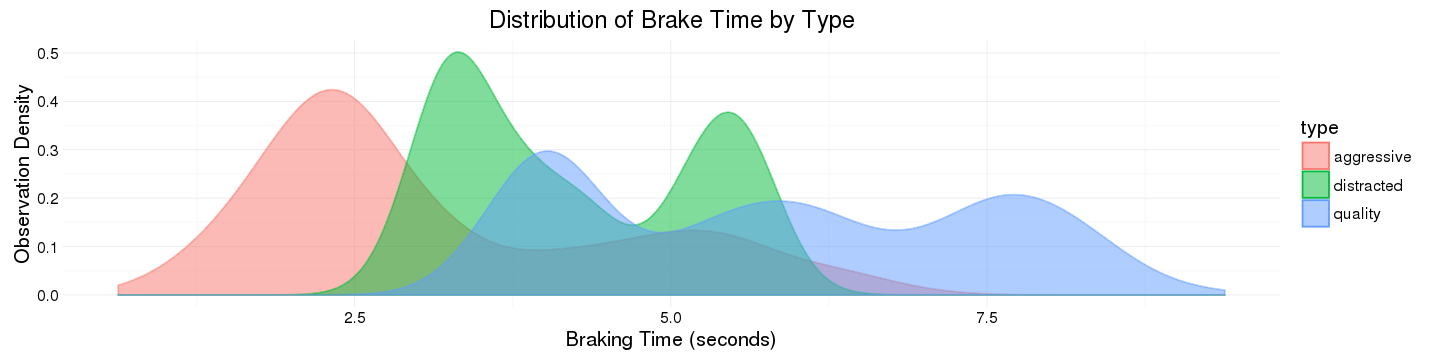

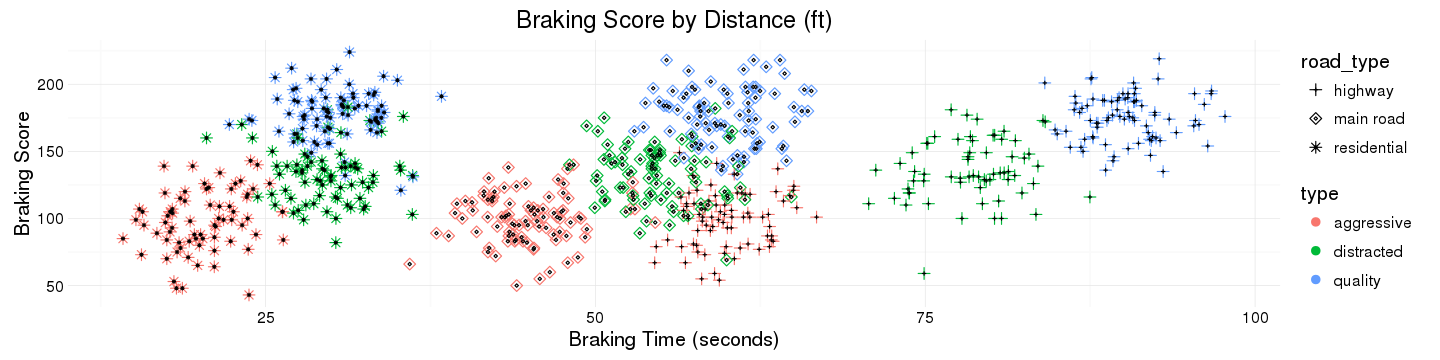

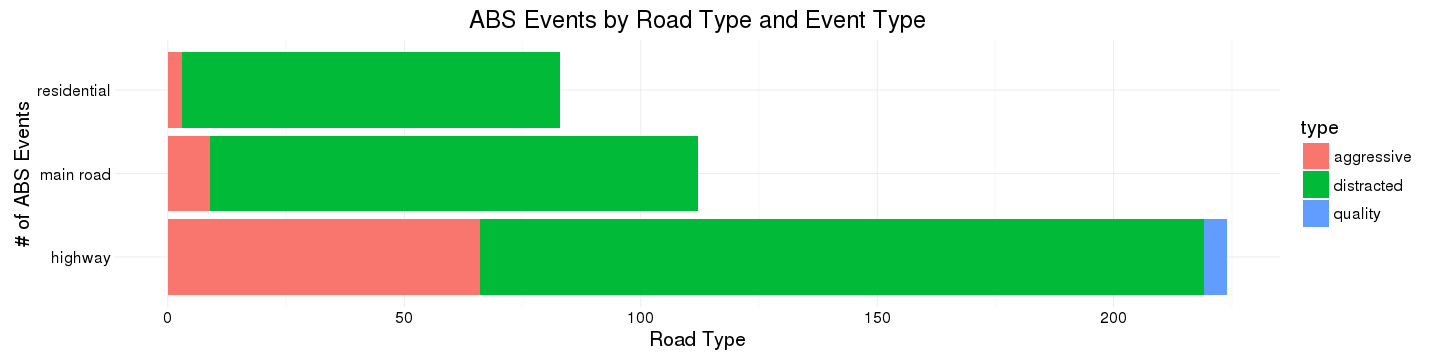

In [4]:
options(repr.plot.width = 12, repr.plot.height = 3)

ggplot(brakeEventDF, aes(x = brake_time_sec, color = type, fill = type)) + 
    geom_density(alpha = 0.5) +
    labs(x = "Braking Time (seconds)", y = "Observation Density", title = "Distribution of Brake Time by Type") +
    theme_minimal()

ggplot(sample_frac(brakeEventDF, .33), aes(x = brake_distance_ft, y = braking_score)) + 
    geom_point(aes(shape = road_type, color = type), size = 2) +
    scale_shape_manual(values=c(3, 5, 8)) +
    geom_point(color = 'black', size = 0.35, aes(shape = road_type)) +
    labs(x = "Braking Distance (feet)", y = "Braking Score", title = "Braking Score by Distance (ft)") +
    theme_minimal()

ggplot(aggDF, aes(x = road_type, y = abs_events)) + 
    geom_bar(aes(fill = type), stat = 'identity') + 
    coord_flip() +
    labs(x = "# of ABS Events", y = "Road Type", title = "ABS Events by Road Type and Event Type") +
    theme_minimal()

After visually inspecting the data, we see some clear grouping along the lines of event type, road type, and number of ABS events.  There is also an obvious linear relationship between brake score and brake time.  This historical data is clean enough to build a model from.

__________

<a id='ml'></a>


### Modeling

We can train a decision tree model on the historical brake event data.  It will learn the relationship between the various quantitative variables and the type of brake event, allowing us to classify new records as they come in.  In this case, we will be checking the behavior of drivers making warranty claims.

We have another data set to test the model on, so in this case we don't need to split into train and test sets.  The following cell trains the model and tests its accuracy.

In [5]:
## Preserve VINs to add on after modeling
vins <- brakeEventDF$VIN

## Select columns for modeling
trainingDF <- select(brakeEventDF, type, brake_time_sec, brake_distance_ft, road_type, braking_score, 
                 brake_pressure20pct, brake_pressure40pct, brake_pressure60pct,
                 brake_pressure80pct, brake_pressure100pct, abs_event, travel_speed)

set.seed(22)
brakeEventModel <- randomForest(type ~ ., 
                                data = trainingDF,
                                ntree = 500,
                                proximity = TRUE)

## Load test set
testingDF <-  read.csv(file = getObjectStorageFileWithCredentials_d7a568f8ac534bc48834f0e1762068f9("DataScienceforAutomotiveWorkshop", "testdata.csv"))

print("Confusion Matrix for Testing Data:")
table(predict(brakeEventModel, select(testingDF, -VIN, -type)), testingDF$type)

[1] "Confusion Matrix for Testing Data:"


            
             aggressive distracted quality
  aggressive        268          1       0
  distracted          0        279       2
  quality             0          2     248

The accuracy on this model is strong enough to give us some confidence in using it on new data.  

_________

<a id='export'></a>

### Model Export

We can export the decision tree model to Object Storage for use in our Shiny app.  These credentials will also be hidden.

In [6]:
## Insert your own credentials to Object Storage here, making sure to specify the filename for your model object.

## Provide Credentials from Files/Connections tab in DSX menu bar
creds1 <-list(auth_url = "https://identity.open.softlayer.com",
             project = "object_storage_d7a568f8_ac53_4bc4_8834_000000000",
             project_id = "e0c826f12030000990000fd957621744",
             region = "germany",
             user_id = "69jfh379s810f9988ebc4b",
             domain_id = "47ea410d2b532891279dsfw3fbefe4",
             domain_name =  "1084821",
             username = "username",
             password = "password",
             container = "notebooks", 
             filename = "brakeEventModel.rds")

In [7]:
saveRDS(object = brakeEventModel, file = "brakeEventModel.rds")
status <- objectStore.put(creds1, "brakeEventModel.rds")
paste("Status for model object:", status, sep = " ")

[1] "Status for model object: 201"

The model has successfully been written to Object Storage.  

________

### Conclusion

In this notebook we have quickly explored and visualized brake event data using R.  We've also built, tested, and exported a decision tree model that can be embedded in applications or used to create reports.  To see the Shiny app where this model is used on customers coming into the service bay, head over to [Shinyapps.io](https://kurlare.shinyapps.io/brakeeventanalyzer/) where the app is hosted.

_______


<div><br><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/IBM_logo.svg/640px-IBM_logo.svg.png" width = 200 height = 200>
</div><br>